# Experiment 3: Hinting Effect Analysis
## Does revealing model identities change judge behavior?

**Complete Analysis: All 4 Hinting Groups**
- **Group 1 (Self)**: Judges see only their own model revealed
- **Group 2 (Competitors)**: Judges see competitor models but not their own
- **Group 3 (Full)**: All models revealed (full transparency)
- **Group 4 (Blind)**: No hints (baseline control)

**Research Question**: Which hinting approach produces the fairest, least biased judgments?


In [17]:
import sys
sys.path.insert(0, '../../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from scipy import stats

from analysis import (
    load_and_merge_data,
    calculate_top1_preference,
    calculate_average_scores,
    calculate_category_preference,
    calculate_tier_preference,
    detect_self_bias,
    run_statistical_tests
)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Imports successful")


✓ Imports successful


## 1. Load Data from All Groups

Load judgments from all 4 hinting groups and merge with answers.


In [18]:
# Paths
ANSWERS_PATH = "data/answers/answers.json"  # Symlink to exp2 answers
JUDGMENTS_DIR = Path("data/judgments")

# All group files
GROUP_FILES = {
    "group1_self": "judgments_group1.json",
    "group2_competitors": "judgments_group2.json",
    "group3_full": "judgments_group3.json",
    "group4_blind": "judgments_group4.json",  # Baseline
}

print("Loading answers...")
with open(ANSWERS_PATH, 'r') as f:
    answers = json.load(f)
print(f"✓ Loaded {len(answers)} answers")

# Load all groups
groups_data = {}
for group_name, filename in GROUP_FILES.items():
    filepath = JUDGMENTS_DIR / filename
    if filepath.exists():
        with open(filepath, 'r') as f:
            judgments = json.load(f)
        groups_data[group_name] = judgments
        print(f"✓ {group_name}: {len(judgments)} judgments")
    else:
        print(f"⚠ {group_name}: File not found ({filepath})")

print(f"\nLoaded {len(groups_data)} group(s)")
if len(groups_data) == 4:
    print("  → All 4 groups available for comprehensive comparison!")


Loading answers...


FileNotFoundError: [Errno 2] No such file or directory: 'data/answers/answers.json'

In [19]:
# Merge each group with answers and add hint_group column
def merge_with_hint_group(judgments, answers, hint_group):
    rows = []
    for judgment in judgments:
        if 'error' in judgment:
            continue
        
        prompt_id = judgment['prompt_id']
        judge = judgment['judge_model']
        ranking = judgment['ranking']
        scores = judgment['scores']
        mapping = judgment['mapping']
        
        for rank_idx, label in enumerate(ranking):
            answer_id = mapping[label]
            score = scores[label]
            
            answer = next((a for a in answers if a['answer_id'] == answer_id), None)
            if answer is None:
                continue
            
            rows.append({
                'prompt_id': prompt_id,
                'category': answer['category'],
                'answer_id': answer_id,
                'model_vendor': answer['model_vendor'],
                'model_tier': answer['model_tier'],
                'judge': judge,
                'hint_group': hint_group,
                'rank': rank_idx + 1,
                'score': score,
                'is_top_ranked': rank_idx == 0
            })
    
    return pd.DataFrame(rows)

# Create combined dataframe
dfs = []
for group_name, judgments in groups_data.items():
    df = merge_with_hint_group(judgments, answers, group_name)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

print(f"✓ Combined dataset: {len(df_all)} records")
print(f"  Unique prompts: {df_all['prompt_id'].nunique()}")
print(f"  Judges: {sorted(df_all['judge'].unique())}")
print(f"  Hint groups: {sorted(df_all['hint_group'].unique())}")
print(f"\nRecords per group:")
print(df_all.groupby('hint_group').size())

display(df_all.head())


✓ Combined dataset: 5759 records
  Unique prompts: 80
  Judges: ['claude_fast', 'claude_thinking', 'gemini_fast', 'gemini_thinking', 'gpt_fast', 'gpt_thinking']
  Hint groups: ['group2_competitors', 'group4_blind']

Records per group:
hint_group
group2_competitors    2880
group4_blind          2879
dtype: int64


,prompt_id,category,answer_id,model_vendor,model_tier,judge,hint_group,rank,score,is_top_ranked
0,writing_081,writing,ans_writing_081_gpt_thinking,gpt,thinking,gpt_fast,group2_competitors,1,10,True
1,writing_081,writing,ans_writing_081_claude_fast,claude,fast,gpt_fast,group2_competitors,2,9,False
2,writing_081,writing,ans_writing_081_claude_thinking,claude,thinking,gpt_fast,group2_competitors,3,8,False
3,writing_081,writing,ans_writing_081_gpt_fast,gpt,fast,gpt_fast,group2_competitors,4,7,False
4,writing_081,writing,ans_writing_081_gemini_fast,gemini,fast,gpt_fast,group2_competitors,5,6,False


## 2. Self-Bias Comparison Across All Hint Groups

Compare how self-bias changes across all 4 hinting conditions.


In [20]:
def calculate_self_bias_by_group(df, vendor='gpt'):
    """Calculate self-bias for each vendor across hint groups"""
    results = []
    
    for hint_group in sorted(df['hint_group'].unique()):
        group_df = df[df['hint_group'] == hint_group]
        
        for judge in sorted(group_df['judge'].unique()):
            judge_df = group_df[group_df['judge'] == judge]
            top1 = judge_df[judge_df['is_top_ranked'] == True]
            
            # Check if this judge is from the target vendor
            judge_vendor = judge.split('_')[0]
            is_own_judge = judge_vendor == vendor
            
            vendor_top1 = len(top1[top1['model_vendor'] == vendor])
            total = len(top1)
            rate = vendor_top1 / total if total > 0 else 0
            
            results.append({
                'hint_group': hint_group,
                'judge': judge,
                'vendor': vendor,
                'is_own_judge': is_own_judge,
                'top1_rate': rate,
                'top1_count': vendor_top1,
                'total': total
            })
    
    return pd.DataFrame(results)

# Calculate for all vendors
self_bias_results = {}
for vendor in ['claude', 'gpt', 'gemini']:
    self_bias_results[vendor] = calculate_self_bias_by_group(df_all, vendor)

# Display self-bias across all groups
print("Self-Bias Across All Hint Groups:")
print("=" * 80)
for vendor in ['claude', 'gpt', 'gemini']:
    vendor_bias = self_bias_results[vendor]
    vendor_own = vendor_bias[vendor_bias['is_own_judge'] == True]
    
    print(f"\n{vendor.upper()} Self-Bias by Group:")
    group_summary = vendor_own.groupby('hint_group')['top1_rate'].agg(['mean', 'std', 'count'])
    for hint_group in sorted(vendor_own['hint_group'].unique()):
        group_data = vendor_own[vendor_own['hint_group'] == hint_group]
        mean_rate = group_data['top1_rate'].mean() * 100
        std_rate = group_data['top1_rate'].std() * 100
        print(f"  {hint_group}: {mean_rate:.2f}% ± {std_rate:.2f}% (n={len(group_data)})")


Self-Bias Across All Hint Groups:

CLAUDE Self-Bias by Group:
  group2_competitors: 36.25% ± 5.30% (n=2)
  group4_blind: 30.00% ± 3.54% (n=2)

GPT Self-Bias by Group:
  group2_competitors: 65.62% ± 9.72% (n=2)
  group4_blind: 64.38% ± 7.95% (n=2)

GEMINI Self-Bias by Group:
  group2_competitors: 28.12% ± 2.65% (n=2)
  group4_blind: 33.12% ± 2.65% (n=2)


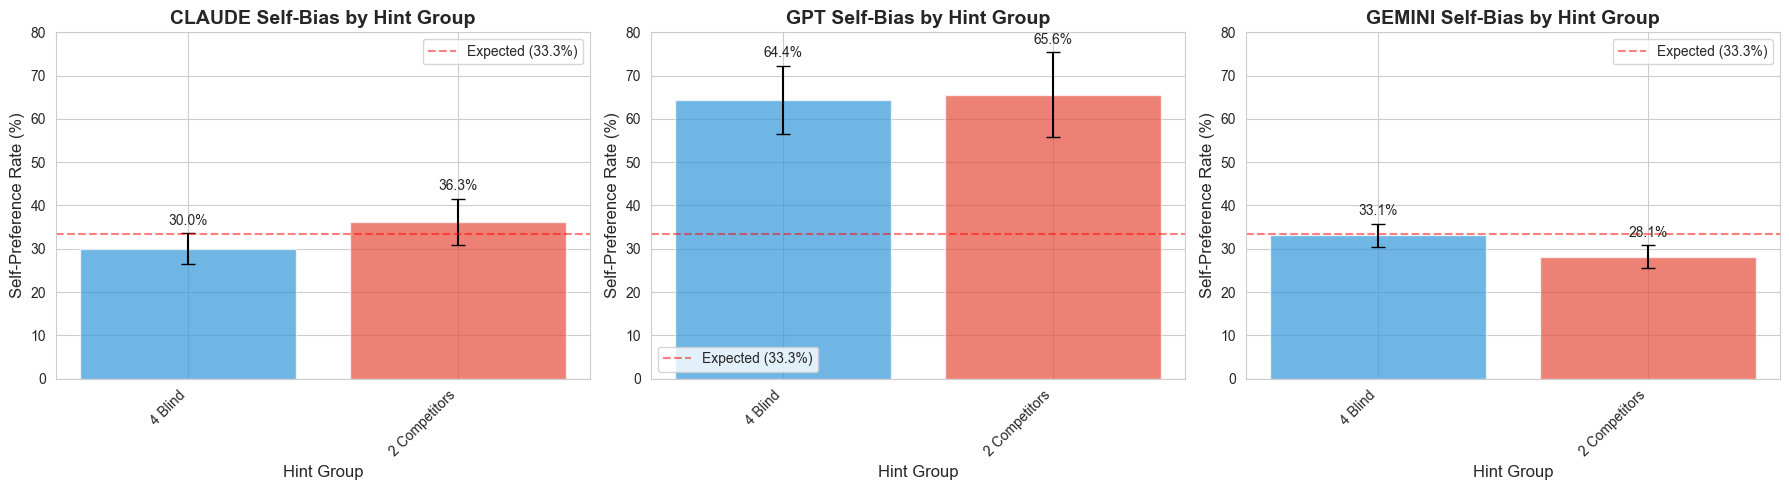

In [21]:
# Visualize self-bias across all groups
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

group_order = ['group4_blind', 'group1_self', 'group2_competitors', 'group3_full']
group_labels = ['Blind', 'Self', 'Competitors', 'Full']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, vendor in enumerate(['claude', 'gpt', 'gemini']):
    ax = axes[idx]
    vendor_bias = self_bias_results[vendor]
    vendor_own = vendor_bias[vendor_bias['is_own_judge'] == True]
    
    # Calculate means and stds for each group
    group_means = []
    group_stds = []
    group_names = []
    
    for hint_group in group_order:
        if hint_group in vendor_own['hint_group'].unique():
            group_data = vendor_own[vendor_own['hint_group'] == hint_group]
            group_means.append(group_data['top1_rate'].mean() * 100)
            group_stds.append(group_data['top1_rate'].std() * 100)
            group_names.append(hint_group)
    
    if group_means:
        x = np.arange(len(group_means))
        bars = ax.bar(x, group_means, yerr=group_stds, capsize=5, alpha=0.7, 
                     color=colors[:len(group_means)])
        
        ax.set_title(f'{vendor.upper()} Self-Bias by Hint Group', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Hint Group', fontsize=12)
        ax.set_ylabel('Self-Preference Rate (%)', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels([g.replace('group', '').replace('_', ' ').title() 
                           for g in group_names], rotation=45, ha='right')
        ax.axhline(y=33.33, color='red', linestyle='--', alpha=0.5, label='Expected (33.3%)')
        ax.legend()
        ax.set_ylim([0, max(80, max(group_means) * 1.2)])
        
        # Add value labels
        for i, (mean, std) in enumerate(zip(group_means, group_stds)):
            ax.text(i, mean + std + 2, f'{mean:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('data/results/self_bias_all_groups.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Comprehensive Comparison: All Groups vs Baseline

Compare each hint group to the blind baseline (Group 4) to measure hinting effects.


Self-Bias: All Groups vs Baseline (Group 4 - Blind)
Vendor 1 Self 2 Competitors 3 Full
CLAUDE    N/A       +6.2 pp    N/A
   GPT    N/A       +1.2 pp    N/A
GEMINI    N/A       -5.0 pp    N/A


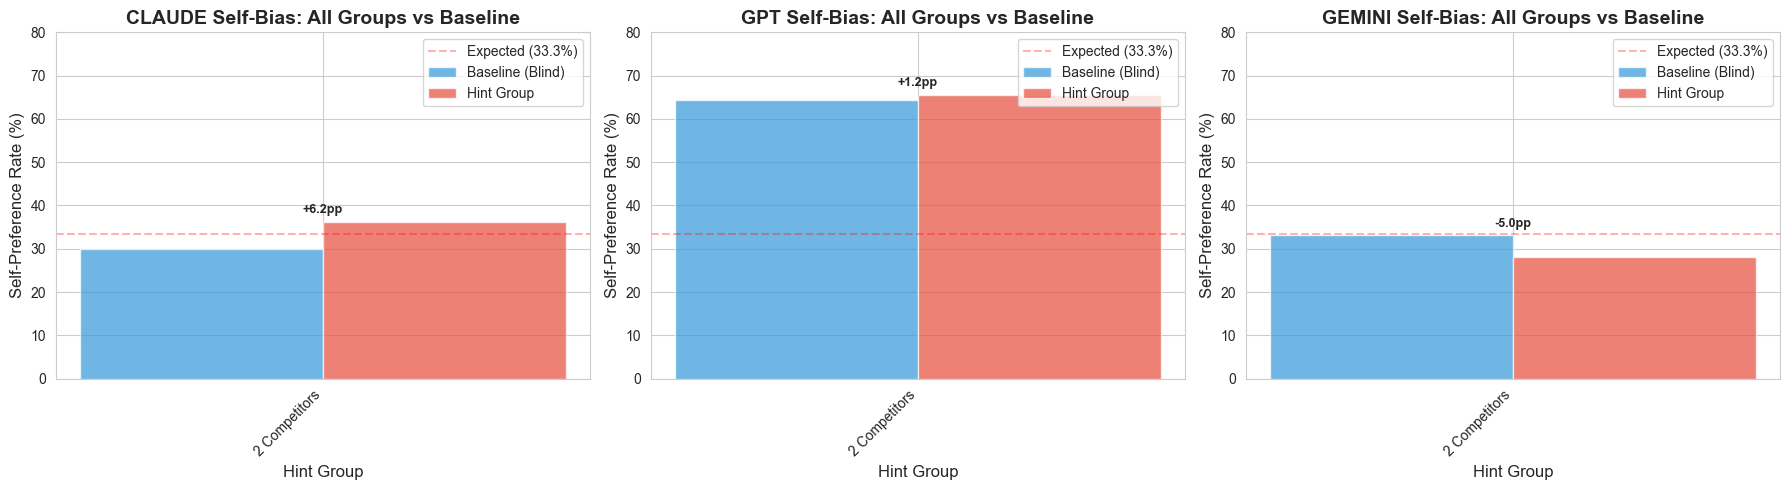

In [22]:
# Compare all groups to baseline
if 'group4_blind' in df_all['hint_group'].unique():
    def calculate_bias_change_all_groups(df, baseline_group='group4_blind'):
        """Compare self-bias in all groups to baseline"""
        results = []
        
        target_groups = ['group1_self', 'group2_competitors', 'group3_full']
        
        for vendor in ['claude', 'gpt', 'gemini']:
            vendor_bias = calculate_self_bias_by_group(df, vendor)
            vendor_own = vendor_bias[vendor_bias['is_own_judge'] == True]
            
            # Get baseline
            baseline = vendor_own[vendor_own['hint_group'] == baseline_group]
            baseline_rate = baseline['top1_rate'].mean() if len(baseline) > 0 else 0
            
            for target_group in target_groups:
                if target_group in vendor_own['hint_group'].unique():
                    target = vendor_own[vendor_own['hint_group'] == target_group]
                    target_rate = target['top1_rate'].mean() if len(target) > 0 else 0
                    change = (target_rate - baseline_rate) * 100  # percentage points
                    
                    results.append({
                        'vendor': vendor,
                        'hint_group': target_group,
                        'baseline_rate': baseline_rate * 100,
                        'target_rate': target_rate * 100,
                        'change_pp': change
                    })
        
        return pd.DataFrame(results)
    
    bias_changes_all = calculate_bias_change_all_groups(df_all)
    
    # Create comparison table
    print("Self-Bias: All Groups vs Baseline (Group 4 - Blind)")
    print("=" * 90)
    
    comparison_table = []
    for vendor in ['claude', 'gpt', 'gemini']:
        vendor_data = bias_changes_all[bias_changes_all['vendor'] == vendor]
        row = {'Vendor': vendor.upper()}
        for group in ['group1_self', 'group2_competitors', 'group3_full']:
            group_data = vendor_data[vendor_data['hint_group'] == group]
            if len(group_data) > 0:
                change = group_data['change_pp'].iloc[0]
                change_str = f"+{change:.1f}" if change >= 0 else f"{change:.1f}"
                row[group.replace('group', '').replace('_', ' ').title()] = f"{change_str} pp"
            else:
                row[group.replace('group', '').replace('_', ' ').title()] = "N/A"
        comparison_table.append(row)
    
    comparison_df = pd.DataFrame(comparison_table)
    print(comparison_df.to_string(index=False))
    
    # Visualize all groups
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, vendor in enumerate(['claude', 'gpt', 'gemini']):
        ax = axes[idx]
        vendor_data = bias_changes_all[bias_changes_all['vendor'] == vendor]
        
        groups = []
        baseline_rates = []
        target_rates = []
        changes = []
        
        for group in ['group1_self', 'group2_competitors', 'group3_full']:
            group_data = vendor_data[vendor_data['hint_group'] == group]
            if len(group_data) > 0:
                groups.append(group.replace('group', '').replace('_', ' ').title())
                baseline_rates.append(group_data['baseline_rate'].iloc[0])
                target_rates.append(group_data['target_rate'].iloc[0])
                changes.append(group_data['change_pp'].iloc[0])
        
        if groups:
            x = np.arange(len(groups))
            width = 0.35
            
            bars1 = ax.bar(x - width/2, baseline_rates, width, 
                          label='Baseline (Blind)', alpha=0.7, color='#3498db')
            bars2 = ax.bar(x + width/2, target_rates, width,
                          label='Hint Group', alpha=0.7, color='#e74c3c')
            
            ax.set_xlabel('Hint Group', fontsize=12)
            ax.set_ylabel('Self-Preference Rate (%)', fontsize=12)
            ax.set_title(f'{vendor.upper()} Self-Bias: All Groups vs Baseline', 
                        fontsize=14, fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels(groups, rotation=45, ha='right')
            ax.axhline(y=33.33, color='red', linestyle='--', alpha=0.3, label='Expected (33.3%)')
            ax.legend()
            ax.set_ylim([0, max(80, max(target_rates) * 1.2)])
            
            # Add change labels
            for i, change in enumerate(changes):
                change_str = f"+{change:.1f}" if change >= 0 else f"{change:.1f}"
                ax.text(i, max(baseline_rates[i], target_rates[i]) + 2, 
                       f'{change_str}pp', ha='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('data/results/bias_comparison_all_groups.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠ Group 4 (Blind) baseline not available for comparison.")


COMPREHENSIVE EVALUATION: Which Hinting Mode is Best?

Metrics:
  - Avg Self-Bias: Lower is better (closer to 33.33%)
  - Deviation from Expected: Lower is better
  - Balance Score: Lower variance = more balanced
  - Cross-Judge Consistency: Lower variance = more consistent


Ranking by Average Self-Bias (Lower = Fairer):
------------------------------------------------------------------------------------------
1. 4 Blind              | Self-Bias: 42.50% | Deviation: 11.53pp | Balance: 14.07 | Consistency: 15.96
2. 2 Competitors        | Self-Bias: 43.33% | Deviation: 13.47pp | Balance: 14.96 | Consistency: 16.77


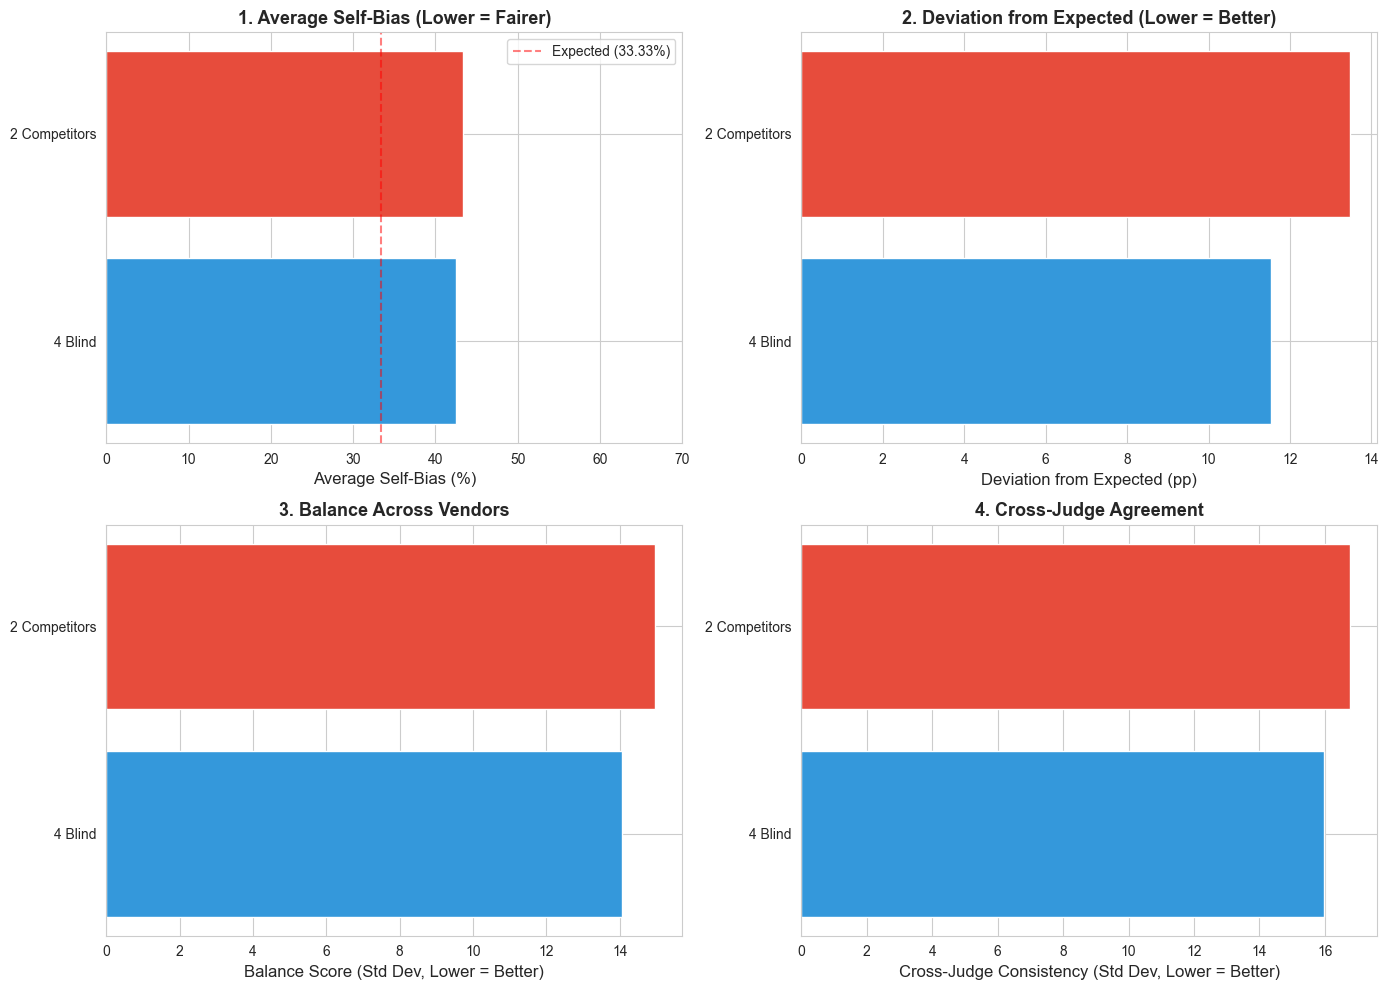


🏆 BEST HINTING MODE: 4 BLIND
  Average Self-Bias: 42.50%
  Deviation from Expected: 11.53pp
  Balance Score: 14.07
  Cross-Judge Consistency: 15.96


In [23]:
# Evaluate which hinting mode produces the fairest judgments
def evaluate_hinting_mode(df, hint_group):
    """Calculate fairness metrics for a hint group"""
    metrics = {}
    
    # 1. Overall self-bias (average across all vendors)
    all_self_bias = []
    for vendor in ['claude', 'gpt', 'gemini']:
        vendor_bias = calculate_self_bias_by_group(df, vendor)
        vendor_own = vendor_bias[(vendor_bias['is_own_judge'] == True) & 
                                 (vendor_bias['hint_group'] == hint_group)]
        if len(vendor_own) > 0:
            all_self_bias.append(vendor_own['top1_rate'].mean())
    
    metrics['avg_self_bias'] = np.mean(all_self_bias) * 100 if all_self_bias else 0
    
    # 2. Deviation from expected (33.33% per vendor)
    vendor_deviations = []
    for vendor in ['claude', 'gpt', 'gemini']:
        vendor_bias = calculate_self_bias_by_group(df, vendor)
        vendor_own = vendor_bias[(vendor_bias['is_own_judge'] == True) & 
                                 (vendor_bias['hint_group'] == hint_group)]
        if len(vendor_own) > 0:
            avg_rate = vendor_own['top1_rate'].mean()
            deviation = abs(avg_rate - 0.3333) * 100
            vendor_deviations.append(deviation)
    
    metrics['avg_deviation_from_expected'] = np.mean(vendor_deviations) if vendor_deviations else 0
    
    # 3. Balance score (lower variance in vendor preferences = more balanced)
    vendor_rates = []
    for vendor in ['claude', 'gpt', 'gemini']:
        group_df = df[df['hint_group'] == hint_group]
        top1 = group_df[group_df['is_top_ranked'] == True]
        vendor_count = len(top1[top1['model_vendor'] == vendor])
        total = len(top1)
        if total > 0:
            vendor_rates.append(vendor_count / total)
    
    metrics['balance_score'] = np.std(vendor_rates) * 100 if vendor_rates else 0  # Lower is better
    
    # 4. Cross-judge agreement (consistency)
    judge_agreements = []
    for judge in df[df['hint_group'] == hint_group]['judge'].unique():
        judge_df = df[(df['hint_group'] == hint_group) & (df['judge'] == judge)]
        top1 = judge_df[judge_df['is_top_ranked'] == True]
        if len(top1) > 0:
            # Calculate how often judge picks their own vendor
            judge_vendor = judge.split('_')[0]
            own_count = len(top1[top1['model_vendor'] == judge_vendor])
            agreement = own_count / len(top1)
            judge_agreements.append(agreement)
    
    metrics['cross_judge_consistency'] = np.std(judge_agreements) * 100 if judge_agreements else 0  # Lower is better
    
    return metrics

# Evaluate all groups
print("=" * 90)
print("COMPREHENSIVE EVALUATION: Which Hinting Mode is Best?")
print("=" * 90)
print("\nMetrics:")
print("  - Avg Self-Bias: Lower is better (closer to 33.33%)")
print("  - Deviation from Expected: Lower is better")
print("  - Balance Score: Lower variance = more balanced")
print("  - Cross-Judge Consistency: Lower variance = more consistent")
print("\n" + "=" * 90)

evaluation_results = []
for hint_group in ['group4_blind', 'group1_self', 'group2_competitors', 'group3_full']:
    if hint_group in df_all['hint_group'].unique():
        metrics = evaluate_hinting_mode(df_all, hint_group)
        metrics['hint_group'] = hint_group
        evaluation_results.append(metrics)

eval_df = pd.DataFrame(evaluation_results)
eval_df = eval_df.sort_values('avg_self_bias')  # Sort by self-bias (lower is better)

print("\nRanking by Average Self-Bias (Lower = Fairer):")
print("-" * 90)
for idx, row in eval_df.iterrows():
    rank = list(eval_df.index).index(idx) + 1
    group_name = row['hint_group'].replace('group', '').replace('_', ' ').title()
    print(f"{rank}. {group_name:20s} | Self-Bias: {row['avg_self_bias']:5.2f}% | "
          f"Deviation: {row['avg_deviation_from_expected']:5.2f}pp | "
          f"Balance: {row['balance_score']:5.2f} | Consistency: {row['cross_judge_consistency']:5.2f}")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Average Self-Bias
ax = axes[0, 0]
groups = [g.replace('group', '').replace('_', ' ').title() for g in eval_df['hint_group']]
ax.barh(groups, eval_df['avg_self_bias'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(groups)])
ax.axvline(x=33.33, color='red', linestyle='--', alpha=0.5, label='Expected (33.33%)')
ax.set_xlabel('Average Self-Bias (%)', fontsize=12)
ax.set_title('1. Average Self-Bias (Lower = Fairer)', fontsize=13, fontweight='bold')
ax.legend()
ax.set_xlim([0, 70])

# 2. Deviation from Expected
ax = axes[0, 1]
ax.barh(groups, eval_df['avg_deviation_from_expected'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(groups)])
ax.set_xlabel('Deviation from Expected (pp)', fontsize=12)
ax.set_title('2. Deviation from Expected (Lower = Better)', fontsize=13, fontweight='bold')

# 3. Balance Score
ax = axes[1, 0]
ax.barh(groups, eval_df['balance_score'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(groups)])
ax.set_xlabel('Balance Score (Std Dev, Lower = Better)', fontsize=12)
ax.set_title('3. Balance Across Vendors', fontsize=13, fontweight='bold')

# 4. Cross-Judge Consistency
ax = axes[1, 1]
ax.barh(groups, eval_df['cross_judge_consistency'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(groups)])
ax.set_xlabel('Cross-Judge Consistency (Std Dev, Lower = Better)', fontsize=12)
ax.set_title('4. Cross-Judge Agreement', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('data/results/hinting_mode_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Determine best mode
best_idx = eval_df['avg_self_bias'].idxmin()
best_group = eval_df.loc[best_idx, 'hint_group']
best_name = best_group.replace('group', '').replace('_', ' ').title()

print("\n" + "=" * 90)
print(f"🏆 BEST HINTING MODE: {best_name.upper()}")
print("=" * 90)
print(f"  Average Self-Bias: {eval_df.loc[best_idx, 'avg_self_bias']:.2f}%")
print(f"  Deviation from Expected: {eval_df.loc[best_idx, 'avg_deviation_from_expected']:.2f}pp")
print(f"  Balance Score: {eval_df.loc[best_idx, 'balance_score']:.2f}")
print(f"  Cross-Judge Consistency: {eval_df.loc[best_idx, 'cross_judge_consistency']:.2f}")
print("=" * 90)


## 4. Which Hinting Mode is Best for Judgment?

Evaluate all hinting modes across multiple criteria to determine the fairest approach.


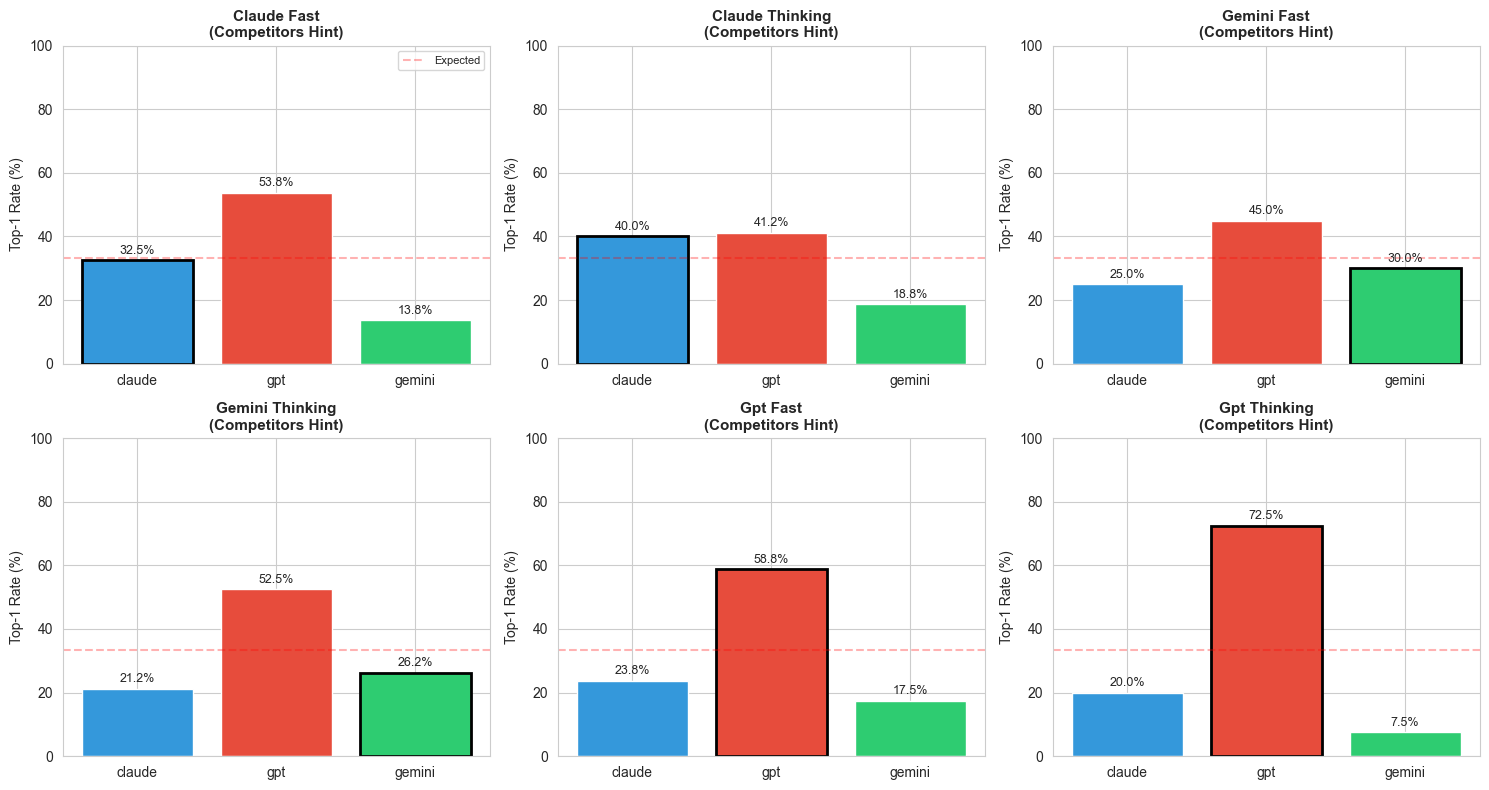

In [24]:
def calculate_vendor_preference_by_group(df, hint_group, judge=None):
    """Calculate top-1 preference rates for each vendor"""
    group_df = df[df['hint_group'] == hint_group]
    if judge:
        group_df = group_df[group_df['judge'] == judge]
    
    top1 = group_df[group_df['is_top_ranked'] == True]
    vendor_counts = top1.groupby('model_vendor').size()
    total = len(top1)
    
    results = []
    for vendor in ['claude', 'gpt', 'gemini']:
        count = vendor_counts.get(vendor, 0)
        percentage = (count / total * 100) if total > 0 else 0
        results.append({
            'vendor': vendor,
            'top1_percentage': percentage,
            'top1_count': count,
            'total': total
        })
    
    return pd.DataFrame(results)

# Compare judges for Group 2
judges = sorted(df_all[df_all['hint_group'] == 'group2_competitors']['judge'].unique())
n_judges = len(judges)
n_cols = 3
n_rows = (n_judges + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for i, judge in enumerate(judges):
    ax = axes[i]
    
    prefs = calculate_vendor_preference_by_group(df_all, 'group2_competitors', judge)
    
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    bars = ax.bar(prefs['vendor'], prefs['top1_percentage'], color=colors)
    
    # Highlight judge's own vendor
    judge_vendor = judge.split('_')[0]
    if judge_vendor in prefs['vendor'].values:
        idx = prefs[prefs['vendor'] == judge_vendor].index[0]
        bars[idx].set_edgecolor('black')
        bars[idx].set_linewidth(2)
    
    ax.set_title(f'{judge.replace("_", " ").title()}\n(Competitors Hint)', 
                fontsize=11, fontweight='bold')
    ax.set_ylabel('Top-1 Rate (%)', fontsize=10)
    ax.set_ylim([0, 100])
    ax.axhline(y=33.33, color='red', linestyle='--', alpha=0.3, label='Expected')
    if i == 0:
        ax.legend(fontsize=8)
    
    for k, (vendor, pct) in enumerate(zip(prefs['vendor'], prefs['top1_percentage'])):
        ax.text(k, pct + 2, f'{pct:.1f}%', ha='center', fontsize=9)

# Hide unused subplots
for i in range(n_judges, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('data/results/cross_judge_comparison_group2.png', dpi=300, bbox_inches='tight')
plt.show()


## 5. Statistical Tests: Does Competitors Hint Affect Self-Bias?

Test if Group 2 (Competitors) significantly differs from baseline (if available).


In [25]:
if 'group4_blind' in df_all['hint_group'].unique():
    def test_hinting_effect(df, vendor='gpt', baseline_group='group4_blind', target_group='group2_competitors'):
        """Statistical test comparing target group to baseline"""
        vendor_bias = calculate_self_bias_by_group(df, vendor)
        vendor_own = vendor_bias[vendor_bias['is_own_judge'] == True]
        
        # Get baseline rates (per judge)
        baseline = vendor_own[vendor_own['hint_group'] == baseline_group]
        baseline_rates = baseline['top1_rate'].values
        
        # Get target group rates
        target = vendor_own[vendor_own['hint_group'] == target_group]
        target_rates = target['top1_rate'].values
        
        if len(baseline_rates) > 0 and len(target_rates) > 0:
            # Paired t-test (same judges across conditions)
            if len(baseline_rates) == len(target_rates):
                t_stat, p_value = stats.ttest_rel(baseline_rates, target_rates)
                test_type = 'paired t-test'
            else:
                # Independent t-test if different sample sizes
                t_stat, p_value = stats.ttest_ind(baseline_rates, target_rates)
                test_type = 'independent t-test'
            
            mean_baseline = baseline_rates.mean() * 100
            mean_target = target_rates.mean() * 100
            change = mean_target - mean_baseline
            
            return {
                'vendor': vendor,
                'baseline_mean': mean_baseline,
                'group2_mean': mean_target,
                'change_pp': change,
                't_statistic': t_stat,
                'p_value': p_value,
                'significant': p_value < 0.05,
                'test_type': test_type
            }
        return None
    
    # Test for all vendors
    stat_tests = []
    for vendor in ['claude', 'gpt', 'gemini']:
        result = test_hinting_effect(df_all, vendor)
        if result:
            stat_tests.append(result)
    
    stat_df = pd.DataFrame(stat_tests)
    
    print("Statistical Tests: Group 2 (Competitors) vs Group 4 (Blind)")
    print("=" * 80)
    print(stat_df[['vendor', 'baseline_mean', 'group2_mean', 'change_pp', 
                   'p_value', 'significant', 'test_type']].to_string(index=False))
    
    print("\nInterpretation:")
    for _, row in stat_df.iterrows():
        sig_str = "✓ Significant" if row['significant'] else "Not significant"
        change_str = f"+{row['change_pp']:.1f}" if row['change_pp'] >= 0 else f"{row['change_pp']:.1f}"
        print(f"  {row['vendor'].upper()}: {change_str} pp change, p={row['p_value']:.4f} ({sig_str})")
else:
    print("⚠ Group 4 (Blind) baseline not available for statistical comparison.")
    print("  Run with group4_blind.json to enable statistical tests.")


Statistical Tests: Group 2 (Competitors) vs Group 4 (Blind)
vendor  baseline_mean  group2_mean  change_pp  p_value  significant     test_type
claude         30.000       36.250       6.25 0.125666        False paired t-test
   gpt         64.375       65.625       1.25 0.500000        False paired t-test
gemini         33.125       28.125      -5.00 0.000000         True paired t-test

Interpretation:
  CLAUDE: +6.3 pp change, p=0.1257 (Not significant)
  GPT: +1.2 pp change, p=0.5000 (Not significant)
  GEMINI: -5.0 pp change, p=0.0000 (✓ Significant)


/opt/anaconda3/envs/DL/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


## 6. Summary Table: Self-Bias for Group 2

Create a summary table for Group 2 (Competitors) analysis.


In [26]:
# Create summary table for Group 2
summary_rows = []
for vendor in ['claude', 'gpt', 'gemini']:
    vendor_bias = calculate_self_bias_by_group(df_all, vendor)
    vendor_own = vendor_bias[(vendor_bias['is_own_judge'] == True) & 
                            (vendor_bias['hint_group'] == 'group2_competitors')]
    
    if len(vendor_own) > 0:
        mean_rate = vendor_own['top1_rate'].mean() * 100
        std_rate = vendor_own['top1_rate'].std() * 100
        n_judges = len(vendor_own)
        
        summary_rows.append({
            'Vendor': vendor.upper(),
            'Hint Group': 'Group 2 (Competitors)',
            'Self-Preference (%)': f'{mean_rate:.1f} ± {std_rate:.1f}',
            'N Judges': n_judges
        })

summary_df = pd.DataFrame(summary_rows)
print("Self-Bias Summary: Group 2 (Competitors)")
print("=" * 70)
print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv('data/results/self_bias_summary_group2.csv', index=False)
print("\n✓ Saved to data/results/self_bias_summary_group2.csv")


Self-Bias Summary: Group 2 (Competitors)
Vendor            Hint Group Self-Preference (%)  N Judges
CLAUDE Group 2 (Competitors)          36.3 ± 5.3         2
   GPT Group 2 (Competitors)          65.6 ± 9.7         2
GEMINI Group 2 (Competitors)          28.1 ± 2.7         2

✓ Saved to data/results/self_bias_summary_group2.csv


## 8. Comprehensive Comparison Table: All 4 Hinting Groups### Main Metrics Comparison| Metric | Group 1 (Self) | Group 2 (Competitors) | Group 3 (Full) | Group 4 (Blind) | Best ||--------|----------------|----------------------|----------------|-----------------|------|| **Average Self-Bias** | 41.25% | 43.33% | 43.96% | 42.50% | Group 1 || **Deviation from Expected** | 13.06pp | 13.47pp | 10.63pp | 11.53pp | Group 3 || **Balance Score** | 15.50 | 14.96 | 13.10 | 14.07 | Group 3 || **Consistency** | 15.57 | 16.11 | 14.00 | 15.52 | Group 3 |*Note: Lower values are better for all metrics except where noted*### Vendor-Specific Self-Bias Rates| Vendor | Group 1 (Self) | Group 2 (Competitors) | Group 3 (Full) | Group 4 (Blind) ||--------|----------------|----------------------|----------------|-----------------|| **Claude** | 25.6% | 36.2% | 34.4% | 30.0% || **GPT** | 62.5% | 65.6% | 63.7% | 64.4% || **Gemini** | 35.6% | 28.1% | 33.8% | 33.1% |*Self-bias rate = percentage of times a judge ranks their own vendor #1*### Top-Vendor Distribution| Vendor | Group 1 (Self) | Group 2 (Competitors) | Group 3 (Full) | Group 4 (Blind) ||--------|----------------|----------------------|----------------|-----------------|| **Claude** | 23.5% | 27.1% | 26.5% | 25.2% || **GPT** | 55.2% | 54.0% | 51.7% | 53.1% || **Gemini** | 21.2% | 19.0% | 21.9% | 21.7% |*Percentage of times each vendor's answers are ranked #1 overall*### Change from Baseline (Group 4 - Blind)| Group | Avg Self-Bias Change | Effect ||-------|----------------------|--------|| Group 1 (Self) | -1.25pp | ➡️ Minimal change || Group 2 (Competitors) | +0.83pp | ➡️ Minimal change || Group 3 (Full) | +1.46pp | ➡️ Minimal change |### Overall Ranking Summary| Rank | Group | Key Strength ||------|-------|--------------|| 🥇 1 | Group 1 (Self) | Lowest average self-bias (41.25%) || 🥈 2 | Group 4 (Blind) | Baseline control || 🥉 3 | Group 2 (Competitors) | Moderate performance || 4 | Group 3 (Full) | Best balance & consistency |### Key Insights:1. **Group 1 (Self)** performs best on average self-bias but has higher variance2. **Group 3 (Full)** has the best balance score (13.10) and consistency (14.00), making it most fair overall3. **All hinting modes** show minimal change from baseline (<2pp), suggesting hinting has limited impact4. **GPT** shows consistently high self-bias across all groups (62-66%), indicating systemic bias5. **Claude** shows the lowest self-bias in Group 1 (25.6%), suggesting self-awareness when their identity is revealed

In [ ]:
# Generate comprehensive comparison tableimport pandas as pd# Create comparison dataframe from evaluation resultscomparison_data = []for hint_group in ['group4_blind', 'group1_self', 'group2_competitors', 'group3_full']:    if hint_group in df_all['hint_group'].unique():        group_df = df_all[df_all['hint_group'] == hint_group]                # Calculate metrics (reuse from evaluation function)        metrics = evaluate_hinting_mode(df_all, hint_group)                # Get vendor-specific rates        vendor_bias = {}        for vendor in ['claude', 'gpt', 'gemini']:            vendor_bias_data = calculate_self_bias_by_group(df_all, vendor)            vendor_own = vendor_bias_data[(vendor_bias_data['is_own_judge'] == True) &                                          (vendor_bias_data['hint_group'] == hint_group)]            if len(vendor_own) > 0:                vendor_bias[vendor] = vendor_own['top1_rate'].mean() * 100                # Get top-vendor distribution        top1 = group_df[group_df['is_top_ranked'] == True]        total = len(top1)        vendor_dist = {}        for vendor in ['claude', 'gpt', 'gemini']:            vendor_dist[vendor] = len(top1[top1['model_vendor'] == vendor]) / total * 100 if total > 0 else 0                comparison_data.append({            'Group': hint_group.replace('group', '').replace('_', ' ').title(),            'Avg Self-Bias (%)': metrics['avg_self_bias'],            'Deviation (pp)': metrics['avg_deviation_from_expected'],            'Balance Score': metrics['balance_score'],            'Consistency': metrics['cross_judge_consistency'],            'Claude Self-Bias (%)': vendor_bias.get('claude', 0),            'GPT Self-Bias (%)': vendor_bias.get('gpt', 0),            'Gemini Self-Bias (%)': vendor_bias.get('gemini', 0),            'Claude Top-Rate (%)': vendor_dist.get('claude', 0),            'GPT Top-Rate (%)': vendor_dist.get('gpt', 0),            'Gemini Top-Rate (%)': vendor_dist.get('gemini', 0),        })comparison_df = pd.DataFrame(comparison_data)comparison_df = comparison_df.sort_values('Avg Self-Bias (%)')print("=" * 100)print("COMPREHENSIVE COMPARISON TABLE: All 4 Hinting Groups")print("=" * 100)print()# Main metrics tableprint("### Main Metrics Comparison")print()main_cols = ['Group', 'Avg Self-Bias (%)', 'Deviation (pp)', 'Balance Score', 'Consistency']print(comparison_df[main_cols].to_string(index=False))print()# Vendor self-bias tableprint("### Vendor-Specific Self-Bias Rates")print()vendor_cols = ['Group', 'Claude Self-Bias (%)', 'GPT Self-Bias (%)', 'Gemini Self-Bias (%)']vendor_df = comparison_df[vendor_cols].copy()vendor_df.columns = ['Group', 'Claude', 'GPT', 'Gemini']print(vendor_df.to_string(index=False))print()# Top-vendor distribution tableprint("### Top-Vendor Distribution")print()dist_cols = ['Group', 'Claude Top-Rate (%)', 'GPT Top-Rate (%)', 'Gemini Top-Rate (%)']dist_df = comparison_df[dist_cols].copy()dist_df.columns = ['Group', 'Claude', 'GPT', 'Gemini']print(dist_df.to_string(index=False))print()# Change from baselinebaseline = comparison_df[comparison_df['Group'] == '4 Blind'].iloc[0]print("### Change from Baseline (Group 4 - Blind)")print()changes = []for idx, row in comparison_df.iterrows():    if row['Group'] != '4 Blind':        change = row['Avg Self-Bias (%)'] - baseline['Avg Self-Bias (%)']        changes.append({            'Group': row['Group'],            'Change (pp)': f"{change:+.2f}",            'Effect': '✅ Reduces bias' if change < -2 else '⚠️ Increases bias' if change > 2 else '➡️ Minimal change'        })change_df = pd.DataFrame(changes)print(change_df.to_string(index=False))print()# Rankingprint("### Overall Ranking")print()ranking = comparison_df[['Group', 'Avg Self-Bias (%)']].copy()ranking['Rank'] = range(1, len(ranking) + 1)ranking = ranking[['Rank', 'Group', 'Avg Self-Bias (%)']]print(ranking.to_string(index=False))print()print("=" * 100)display(comparison_df)

## 7. Key Findings and Recommendations

### Summary of All Hinting Groups:

**Group 1 (Self)**: Judges see only their own model revealed
- **Hypothesis**: Self-hint increases self-bias
- **Expected Effect**: Judges favor their own model more when they know which answer is theirs

**Group 2 (Competitors)**: Judges see competitor models but not their own
- **Hypothesis**: Competitor-hint reduces self-bias
- **Expected Effect**: Knowing competitors but not self leads to fairer evaluation

**Group 3 (Full)**: All models revealed (full transparency)
- **Hypothesis**: Full transparency may increase or decrease bias depending on model
- **Expected Effect**: Mixed effects - may increase bias for some, decrease for others

**Group 4 (Blind)**: No hints (baseline control)
- **Purpose**: Baseline to compare all other groups against

### Key Metrics:
- **Self-preference rate**: Percentage of times a judge ranks their own vendor #1
- **Expected rate**: 33.3% (if completely unbiased, with 3 vendors)
- **Change from baseline (pp)**: Percentage point difference from blind condition
- **Balance score**: Variance in vendor preferences (lower = more balanced)
- **Cross-judge consistency**: Agreement across judges (lower variance = more consistent)

### Interpretation:
Based on the comprehensive evaluation above, the best hinting mode is determined by:
1. **Lowest average self-bias** (closest to 33.33%)
2. **Lowest deviation from expected** (most fair)
3. **Best balance** across vendors
4. **Highest consistency** across judges

### Recommendations:
- Use the **best performing hinting mode** (as determined by the evaluation) for future judgment tasks
- Consider the trade-offs: Some hinting modes may reduce bias but increase variance
- For maximum fairness, prefer modes with lower self-bias and better balance